In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
player_play = pd.read_csv('data/player_play.csv')
player_tracking = pd.read_csv('data/tracking_week_1.csv')
plays = pd.read_csv('data/plays.csv')
players = pd.read_csv('data/players.csv')

In [3]:
player_play['causedPressure'] = player_play['causedPressure'].astype(int)
pressure_on_play = player_play.groupby(['gameId', 'playId'])['causedPressure'].max().reset_index() #binary column to indicate whether there was at least one pressure on the play
data = pd.merge(pressure_on_play, plays, on = ['gameId', 'playId'], how='left')
model_data = data[(data['isDropback']) & (data['qbSpike'] != True)] #only passing plays (plays where qb had a dropback)

In [4]:
model_data['causedPressure'].value_counts()

causedPressure
0    6448
1    3265
Name: count, dtype: int64

In [5]:
model_data.to_csv('model_data.csv', index=False)

In [28]:
tracking_raw = pd.read_csv('data/tracking_week_1.csv')

In [29]:
tracking = pd.merge(tracking_raw, plays.loc[:, ['gameId', 'playId', 'absoluteYardlineNumber']], on = ['gameId', 'playId'], how='left')

In [31]:
def set_up_tracking(tracking_data):
    #Set up tracking data
    tracking_pre_snap = tracking_data[tracking_data['frameType'] == "BEFORE_SNAP"]
    tracking_pre_snap = pd.merge(tracking_pre_snap, plays[['gameId', 'playId', 'isDropback']], on = ['gameId', 'playId'], how = 'inner')
    tracking_pre_snap = tracking_pre_snap[tracking_pre_snap['isDropback']]

    tracking_pre_snap = tracking_pre_snap.groupby(['gameId', 'playId', 'nflId']).last().reset_index()
    #add player positions to filter out defensive backs
    positions = players[['nflId', 'position']]
    tracking_pre_snap = pd.merge(tracking_pre_snap, positions, on = 'nflId', how='inner')
    #find vertical distance between player and football
    tracking_pre_snap['distance_from_line'] = np.abs(tracking_pre_snap['x'] - tracking_pre_snap['absoluteYardlineNumber'])
    return tracking_pre_snap

In [32]:
def create_linspread_feature(model_data, tracking_pre_snap):
    """
    Takes tracking data and calculates the spread among defensive lineman before the snap and returns this as a feature in the overall model_data
    """
    tracking_pre_snap = tracking_pre_snap[tracking_pre_snap['position'].isin(['DE', 'NT', 'SS', 'FS', 'OLB', 'DT', 'CB', 'ILB', 'MLB', 'DB', 'LB'])]
    #filter out DBs and have other players need to be within 1.5 yards of the ball to be determined on the line
    line_spread = tracking_pre_snap.loc[(tracking_pre_snap['distance_from_line'] <= 2) & ~(tracking_pre_snap['position'].isin(['SS', 'FS', 'DB', 'CB']))]
    #find minimum horziontal and maximum horizontal position of filtered lineman
    spread = line_spread.groupby(['gameId', 'playId'])['y'].agg(['max', 'min']).reset_index()
    #calculate dline spread
    spread['dlinespread'] = spread['max'] - spread['min']
    model_data = pd.merge(model_data, spread.loc[:,['gameId', 'playId', 'dlinespread']], on = ['gameId', 'playId'], how='left')
    return model_data

In [37]:
tracking_df['position'].unique()

array(['G', 'ILB', 'DT', 'C', 'WR', 'CB', 'DE', 'T', 'QB', 'SS', 'RB',
       'TE', 'NT', 'FS', 'OLB', 'FB', 'MLB', 'DB', 'LB'], dtype=object)

In [33]:
tracking_df = set_up_tracking(tracking)

In [38]:
lineman = tracking_df.loc[(tracking_df['distance_from_line'] <= 2) & (tracking_df['position'].isin(['DE', 'NT', 'OLB', 'DT', 'ILB', 'MLB', 'LB', 'G', 'C', 'T']))]

In [42]:
position_dict = {
    'G':1, 'DT':0, 'C':1, 'DE':0, 'T':1, 'NT':0, 'OLB':0, 'MLB':0, 'ILB':0, 'LB':0
}

In [43]:
lineman['is_offense'] = lineman['position'].map(position_dict)

C:\Users\johng\AppData\Local\Temp\ipykernel_5168\2317376222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineman['is_offense'] = lineman['position'].map(position_dict)


In [53]:
lineman['max_distance_to_offense'] = np.nan
for (game, play), play_df in lineman.groupby(['gameId', 'playId']):
    offense = play_df[play_df['is_offense'] == 1]
    defense = play_df[play_df['is_offense'] == 0]

    offense_coords = offense[['x', 'y']].values
    defense_coords = defense[['x', 'y']].values

    distances = np.sqrt(
            ((defense_coords[:, np.newaxis, 0] - offense_coords[:, 0]) ** 2) +
            ((defense_coords[:, np.newaxis, 1] - offense_coords[:, 1]) ** 2)
        )
    
    min_distances = distances.min(axis=1)

    lineman.loc[defense.index, 'max_distance_to_offense'] = min_distances

C:\Users\johng\AppData\Local\Temp\ipykernel_5168\3149982828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineman['max_distance_to_offense'] = np.nan


In [54]:
max_lineman_dist = lineman.groupby(['gameId', 'playId'])['max_distance_to_offense'].max().reset_index()

In [56]:
model_data = pd.merge(model_data, max_lineman_dist, on =['gameId', 'playId'], how = 'left')

In [85]:
model_data = create_linspread_feature(model_data, tracking)

In [88]:
model_data['dlinespread_group'] = pd.qcut(model_data['dlinespread'], q=8)

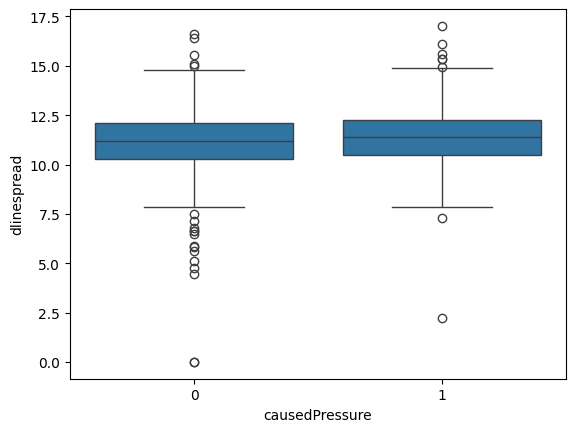

In [54]:
sns.boxplot(x='causedPressure', y='dlinespread', data=model_data)
plt.show()

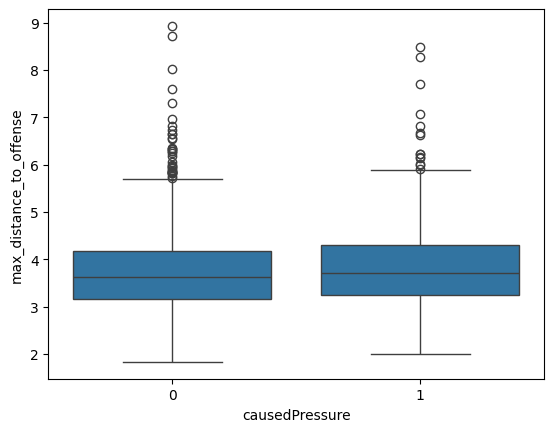

In [57]:
sns.boxplot(x='causedPressure', y='max_distance_to_offense', data=model_data)
plt.show()

In [31]:
test = tracking_pre_snap[(tracking_pre_snap['gameId'] == 2022091200) & (tracking_pre_snap['playId'] == 3826)]

In [32]:
test['distance_from_line'] = np.abs(test['x'] - test['footballx'])

C:\Users\johng\AppData\Local\Temp\ipykernel_9120\389045198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['distance_from_line'] = np.abs(test['x'] - test['footballx'])


In [33]:
test[(test['distance_from_line'] < 1.6) & ~(test['position'].isin(['SS', 'FS', 'DB', 'CB']))]

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,...,dis,o,dir,event,isDropback,footballx,footbally,footballs,position,distance_from_line
13365,2022091200,3826,41464.0,Shelby Harris,89,BEFORE_SNAP,2022-09-13 03:05:49.6,93.0,SEA,left,...,0.04,97.05,94.88,line_set,True,64.419998,29.889999,0.0,DT,0.519998
13368,2022091200,3826,43436.0,Quinton Jefferson,89,BEFORE_SNAP,2022-09-13 03:05:49.6,77.0,SEA,left,...,0.02,80.46,25.10,line_set,True,64.419998,29.889999,0.0,DE,0.279998
13373,2022091200,3826,52456.0,Darrell Taylor,89,BEFORE_SNAP,2022-09-13 03:05:49.6,52.0,SEA,left,...,0.01,126.31,56.81,line_set,True,64.419998,29.889999,0.0,OLB,0.649998
13374,2022091200,3826,54505.0,Boye Mafe,89,BEFORE_SNAP,2022-09-13 03:05:49.6,53.0,SEA,left,...,0.02,63.86,39.86,line_set,True,64.419998,29.889999,0.0,OLB,0.449998
